In [ ]:
import subprocess

def kill_cuda_processes():
    # Get the list of process IDs (PIDs) using nvidia-smi
    cmd = "nvidia-smi | grep 'python' | awk '{print $3}'"
    pids_str = subprocess.check_output(cmd, shell=True).decode('utf-8')
    pids = pids_str.split('\n')[:-1]

    # Kill each process by its PID
    for pid in pids:
        try:
            subprocess.run(["kill", "-9", pid])
            print(f"Killed process {pid}")
        except Exception as e:
            print(f"Error killing process {pid}: {e}")

# Run the function
kill_cuda_processes()


In [1]:
#Set this cuda variable
import os

# Set the environment variable
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'

In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print("There are %d GPU(s) available." % torch.cuda.device_count())

    print("We will use the GPU:", torch.cuda.get_device_name(0))

# If not...
elif torch.backends.mps.is_available():
    device = torch.device("mps")

    print("Using mps backend")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-80GB


In [3]:
torch.cuda.empty_cache()

In [4]:
train_dataset = torch.load('train_dataset_magicbrush.pth')
dev_dataset = torch.load('dev_dataset_magicbrush.pth')

In [5]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
train_dataloader = DataLoader(
    train_dataset, sampler=RandomSampler(train_dataset), batch_size=16
)

validation_dataloader = DataLoader(
    dev_dataset, sampler=SequentialSampler(dev_dataset), batch_size=16
)

In [6]:
from transformers import AutoTokenizer, AutoProcessor
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import requests
from PIL import Image
import numpy as np
from io import BytesIO
from diffusers import (
    KandinskyV22Pipeline,
    KandinskyV22PriorEmb2EmbPipeline,
    KandinskyV22PriorPipeline,
)
from diffusers.utils import load_image
from torchvision.transforms import ToPILImage

In [7]:
from transformers import CLIPTextModelWithProjection, CLIPVisionModelWithProjection, BertForSequenceClassification
import torch.nn as nn
from transformers import AdamW
import os


class T2IModel(nn.Module):
    def __init__(self):
        super(T2IModel, self).__init__()
        self.text_model = BertForSequenceClassification.from_pretrained(
            'bert-base-uncased'
        )
        self.vision_model = CLIPVisionModelWithProjection.from_pretrained(
            "kandinsky-community/kandinsky-2-2-prior", subfolder="image_encoder"
        )
        self.fc = nn.Linear(2560, 1280)

    def initialize_optimizer(self):
        params = (
            list(self.fc.parameters())
        )
        optimizer = AdamW(params, lr=1e-4)
        return optimizer

    def forward(self, input_imgs, instructions):
        text_embeds = self.text_model(instructions).text_embeds
        vision_embeds = self.vision_model(input_imgs).image_embeds
        x = torch.cat((vision_embeds, text_embeds), 1)
        x = self.fc(x)
        return x

    def output_embedding(self, target_images):
        target_image_output = self.vision_model(target_images)
        target_image_embeds = target_image_output.image_embeds
        return target_image_embeds

    def custom_loss(self, output_embeddings, target_embeddings):
        mse_loss = nn.MSELoss()
        loss = mse_loss(output_embeddings, target_embeddings)

        return loss

    def save_model(self, output_dir="../model_save/", filename="model_checkpoint.pt"):
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        file_path = output_dir + filename
        print("Saving model to %s" % file_path)

        torch.save(model.state_dict(), file_path)

    def get_cos(self, input1, input2):
        cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
        similarity = cos(input1, input2)
        avg = torch.sum(similarity) / len(similarity)
        return avg

    def metrics(self, input1, input2):
        cos = self.get_cos(input1, input2)
        return [cos]

    def visualization(self, input_img, instruction, negative_instruction = ""):
        output_embeddings = self.forward(input_img, instruction)
        neg_image_embed = self.forward(input_img, negative_instruction)

        pipe = KandinskyV22Pipeline.from_pretrained(
            "kandinsky-community/kandinsky-2-2-decoder", torch_dtype=torch.float16
        )
        pipe.to(device)
        image = pipe(
            image_embeds = output_embeddings,
            negative_image_embeds = neg_image_embed,
            height = 768,
            width = 768,
            num_inference_steps=100,
        ).images

        image[0].save("./out.png")


model = T2IModel()
model.to(device=device)

T2IModel(
  (text_model): CLIPTextModelWithProjection(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 1280)
        (position_embedding): Embedding(77, 1280)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-31): 32 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
              (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
              (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
              (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
            )
            (layer_norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): GELUActivation()
              (fc1): Linear(in_features=1280, out_features=5120, bias=True)
              (fc2): Linear(in_features=5120, out_f

In [8]:
optimizer = model.initialize_optimizer()

/home/sadibha2/.local/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Use the below cell not to retrain but load the model

In [ ]:
import torch

def load_model_from_checkpoint(model, checkpoint_path, device='cuda'):
    """
    Load a PyTorch model from a saved checkpoint.
    
    Parameters:
    - model (torch.nn.Module): The model architecture (untrained).
    - checkpoint_path (str): Path to the saved model checkpoint (.pth file).
    - device (str): Device to which the model should be loaded ('cuda' or 'cpu').

    Returns:
    - model (torch.nn.Module): Model populated with the loaded weights.
    """

    # Load the model state dictionary from the specified path
    state_dict = torch.load(checkpoint_path, map_location=device)
    
    # Load the state dictionary into the model
    model.load_state_dict(state_dict)
    
    # Move the model to the desired device
    model.to(device)
    
    return model

# Usage
loaded_model = load_model_from_checkpoint(model, 'magicbrush_imagewithinstruction_10epochs_full_v2.pth', device='cuda')


### Use the below cell only to re-train or else don't execute

In [9]:
from tqdm.notebook import tqdm
import gc  # Python's garbage collection module
import torch

num_epochs = 10
training_stats = []

for epoch in range(num_epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, num_epochs))
    print('Training...')

    total_train_loss = 0
    model.train()
    
    train_progress = tqdm(train_dataloader, desc="Training", leave=False)
    for batch in train_progress:
        model.zero_grad()

        # forward pass
        input_images = batch[0].to(device)
        instructions = batch[1].to(device) 
        target_images = batch[2].to(device)
        output_embeddings = model(input_images, instructions)
        
        # Generating target embeddings
        target_img_embeddings = model.output_embedding(target_images)  # assuming this returns tensors on the same device as the model

        # Calculate loss
        loss = model.custom_loss(output_embeddings, target_img_embeddings)
        total_train_loss += loss.item()

        # Update the progress bar with the training loss
        train_progress.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # After processing the batch:
        del input_images, instructions, target_images, output_embeddings, target_img_embeddings, loss
        torch.cuda.empty_cache()
        
    avg_train_loss = total_train_loss / len(train_dataloader)
    print("  Average training loss: {0:.2f}".format(avg_train_loss))

    print("")
    print("Running Validation...")
    model.eval()

    total_eval_loss = 0
    avg_cos = 0
    nb_eval_steps = 0
    
    with torch.no_grad():
        val_progress = tqdm(validation_dataloader, desc="Validation", leave=False)
        for batch in val_progress:

            # Forward pass
            input_images = batch[0].to(device)
            instructions = batch[1].to(device) 
            target_images = batch[2].to(device)
            output_embeddings = model(input_images, instructions)
            
            # Generating target embeddings
            target_img_embeddings = model.output_embedding(target_images)  # assuming this returns tensors on the same device as the model

            # Calculate loss
            loss = model.custom_loss(output_embeddings, target_img_embeddings)
            total_eval_loss += loss.item()
            avg_cos += model.get_cos(output_embeddings, target_img_embeddings)

            # Update the progress bar with the validation loss
            val_progress.set_postfix({'validation_loss': '{:.3f}'.format(loss.item()/len(batch))})
            
            # After processing the batch:
            del input_images, instructions, target_images, output_embeddings, target_img_embeddings, loss
            torch.cuda.empty_cache()
        
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))

    avg_cos /= len(validation_dataloader)
    print(" Validation cosine similarity: {0:.2f}".format(avg_cos))
    
    training_stats.append(
        {
            "epoch": epoch + 1,
            "avg_training_loss": avg_train_loss,
            "avg_val_loss": avg_val_loss,
            "avg_cos": avg_cos,
        }
    )

print("Training completed!")


======== Epoch 1 / 10 ========
Training...


Training:   0%|          | 0/551 [00:00<?, ?it/s]

  Average training loss: 0.74

Running Validation...


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

  Validation Loss: 0.53
 Validation cosine similarity: 0.78

======== Epoch 2 / 10 ========
Training...


Training:   0%|          | 0/551 [00:00<?, ?it/s]

  Average training loss: 0.42

Running Validation...


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

  Validation Loss: 0.40
 Validation cosine similarity: 0.84

======== Epoch 3 / 10 ========
Training...


Training:   0%|          | 0/551 [00:00<?, ?it/s]

  Average training loss: 0.32

Running Validation...


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

  Validation Loss: 0.33
 Validation cosine similarity: 0.87

======== Epoch 4 / 10 ========
Training...


Training:   0%|          | 0/551 [00:00<?, ?it/s]

  Average training loss: 0.27

Running Validation...


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

  Validation Loss: 0.30
 Validation cosine similarity: 0.88

======== Epoch 5 / 10 ========
Training...


Training:   0%|          | 0/551 [00:00<?, ?it/s]

  Average training loss: 0.25

Running Validation...


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

  Validation Loss: 0.28
 Validation cosine similarity: 0.89

======== Epoch 6 / 10 ========
Training...


Training:   0%|          | 0/551 [00:00<?, ?it/s]

  Average training loss: 0.23

Running Validation...


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

  Validation Loss: 0.27
 Validation cosine similarity: 0.90

======== Epoch 7 / 10 ========
Training...


Training:   0%|          | 0/551 [00:00<?, ?it/s]

  Average training loss: 0.22

Running Validation...


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

  Validation Loss: 0.26
 Validation cosine similarity: 0.90

======== Epoch 8 / 10 ========
Training...


Training:   0%|          | 0/551 [00:00<?, ?it/s]

  Average training loss: 0.21

Running Validation...


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

  Validation Loss: 0.25
 Validation cosine similarity: 0.90

======== Epoch 9 / 10 ========
Training...


Training:   0%|          | 0/551 [00:00<?, ?it/s]

  Average training loss: 0.21

Running Validation...


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

  Validation Loss: 0.25
 Validation cosine similarity: 0.90

======== Epoch 10 / 10 ========
Training...


Training:   0%|          | 0/551 [00:00<?, ?it/s]

  Average training loss: 0.20

Running Validation...


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

  Validation Loss: 0.25
 Validation cosine similarity: 0.91
Training completed!


In [10]:
torch.save(model.state_dict(), 'magicbrush_kadinsky_imagewithinstruction_10epochs_full_v1.pth')

In [13]:
def compute_max_instruction_length(dataloader, tokenizer):
    """
    Compute the maximum instruction length from the dataloader batches.

    Args:
    - dataloader (DataLoader): DataLoader containing your data.
    - tokenizer: Tokenizer used to tokenize the instructions.

    Returns:
    - int: Maximum instruction length.
    """
    max_len = 0
    
    for batch in dataloader:
        instructions = batch[1]  # Assuming instructions are in position 1 in your batch
        for instruction in instructions:
            decoded_string = tokenizer.decode(instruction)
            tokens = tokenizer.tokenize(decoded_string)
            length = len(tokens)
            if length > max_len:
                max_len = length
                
    return max_len

def custom_encode(instruction, max_len, tokenizer):
    encoded_inst = tokenizer.encode_plus(
    instruction,  # Sentence to encode.
    add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
    max_length=max_len + 10,  # Pad & truncate all sentences.
    pad_to_max_length=True,
    padding="max_length",
    return_tensors="pt",  # Return pytorch tensors
    )
    
    return encoded_inst["input_ids"]
    

In [14]:
from PIL import Image
img = Image.open("cat1.png")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

input_image = processor(images=img, return_tensors="pt")["pixel_values"]

max_len = compute_max_instruction_length(train_dataloader, tokenizer)

instruction = "Put a toy in the cat's mouth."
instruction_1 = "Low quality image"

input_image = input_image.to(device)
instruction = custom_encode(instruction,max_len,tokenizer).to(device)
instruction_1 = custom_encode(instruction_1,max_len,tokenizer).to(device)

model.visualization(input_image, instruction, instruction_1)

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

## Run the below code for plotting metrics

In [11]:
import pandas as pd

pd.set_option("display.precision", 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index("epoch")
df_stats

,avg_training_loss,avg_val_loss,avg_cos
epoch,,,
1,0.74,0.53,"tensor(0.7793, device='cuda:0')"
2,0.42,0.40,"tensor(0.8416, device='cuda:0')"
3,0.32,0.33,"tensor(0.8689, device='cuda:0')"
4,0.27,0.30,"tensor(0.8833, device='cuda:0')"
5,0.25,0.28,"tensor(0.8915, device='cuda:0')"
6,0.23,0.27,"tensor(0.8970, device='cuda:0')"
7,0.22,0.26,"tensor(0.9004, device='cuda:0')"
8,0.21,0.25,"tensor(0.9030, device='cuda:0')"
9,0.21,0.25,"tensor(0.9049, device='cuda:0')"


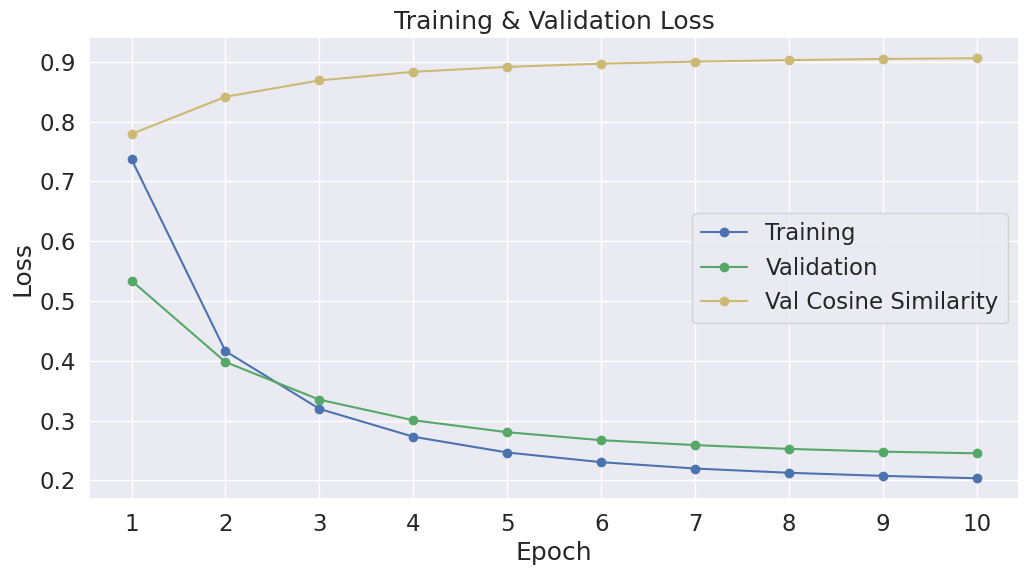

In [12]:
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns


# Use plot styling from seaborn.
sns.set(style="darkgrid")

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12, 6)

# Plot the learning curve.
plt.plot(df_stats["avg_training_loss"], "b-o", label="Training")
plt.plot(df_stats["avg_val_loss"], "g-o", label="Validation")
plt.plot(df_stats["avg_cos"], "y-o", label="Val Cosine Similarity")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(df_stats.index)

plt.show()